## Chapter 2 practice (BEAR DETECTOR)

In [165]:
#|default_exp app

In [166]:
#|export
from fastbook import *
from fastai.vision.widgets import *

In [167]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [108]:
results = search_images_ddg('grizzly bear')

In [109]:
len(results)

200

In [110]:
results[0]

'https://4.bp.blogspot.com/-KliQsenmXqs/Un_rUjF4fII/AAAAAAAABUk/MAbB7TAbOrY/s1600/Grizzly_Bears.jpg'

results contains urls of images

In [10]:

download_url(results[0], dest)

Path('images/grizzly.jpg')

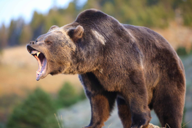

In [111]:
dest = 'images/grizzly.jpg'
img= Image.open(dest)
img.to_thumb(128,300)

In [168]:
#using fast ai download images to download all the urls
bear_types='grizzly' , 'black', 'teddy'
path=Path('bears')

In [13]:
if path.exists():
    print('correct')

    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{0} bear')
        download_images(dest,urls=results)

correct


In [169]:
#List of images paths
fns = get_image_files(path)
fns

(#675) [Path('bears/black/008dbf7d-5f2d-4359-9fd8-ece84b3cf873.jpeg'),Path('bears/black/02bc7777-4ba5-42e4-b52a-62f61f3db560.jpg'),Path('bears/black/049281a0-c44b-46e5-a00b-7e98a4afd48f.jpg'),Path('bears/black/04ad0d06-9c55-4735-aa35-c3d27b8e15cb.jpg'),Path('bears/black/056565ac-72fb-4b71-bac5-58b32627a7e2.jpg'),Path('bears/black/05ad705c-6908-4d1b-a99f-ea830ba38d73.jpg'),Path('bears/black/061697ae-17a2-4c93-9664-608b466f3986.jpg'),Path('bears/black/063e5aff-4dd6-4847-9c94-cd457884b6ff.jpg'),Path('bears/black/0704dac0-1a6b-4687-abb6-f8669e61f627.jpg'),Path('bears/black/08e3c1dc-c989-4395-b392-c5fbb02b3038.jpg')...]

In [170]:
# checking corrupt files
failed = verify_images(fns)
failed

(#0) []

In [171]:
# failed returns list of corrupt file paths, and failed.map iterates through every one of them and unlinks then from Path
failed.map(Path.unlink);

In [172]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      c:\anaconda3\envs\fastbook\lib\site-packages\fastai\vision\utils.py
Type:      function

In [173]:
doc(verify_images)

# Dataloader Class
class Dataloaders(GetAttr):
    def __init__(self,*loaders):self.loaders=loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i, self:self[i])

To convert our downloaded data into a dataloaders object we need:
1) What kind of data we are working with
2) How to get the list of items
3) How to label these items
4) How to create validation set

In [174]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

blocks=(ImageBlock, CategoryBlock)
The independent variable is the thing we are using to make predictions from, and the dependent variable is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of bear) for each image.

The get_image_files function takes a path, and returns a list of all of the images in that path (recursively, by default)

The independent variable is often referred to as x and the dependent variable is often referred to as y. Here, we are telling fastai what function to call to create the labels in our dataset:

get_y=parent_label
parent_label is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a mini-batch). To group them in a big array (usually called a tensor) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. Item transforms are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the Resize transform here:

item_tfms=Resize(128)

In [175]:
dls = bears.dataloaders(path)

A DataLoaders includes validation and training DataLoaders. DataLoader is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a DataLoader fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the show_batch method on a DataLoader:

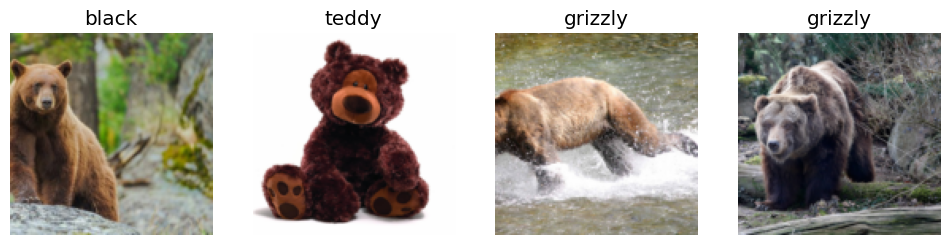

In [176]:
dls.train.show_batch(max_n=4, nrows=1)

By default resize crops the images to fit a square shape of the size requested, using the full width or height.This can result in losing some important details. Alternatively we can pad the images with zeros(black), or squish/strech them:

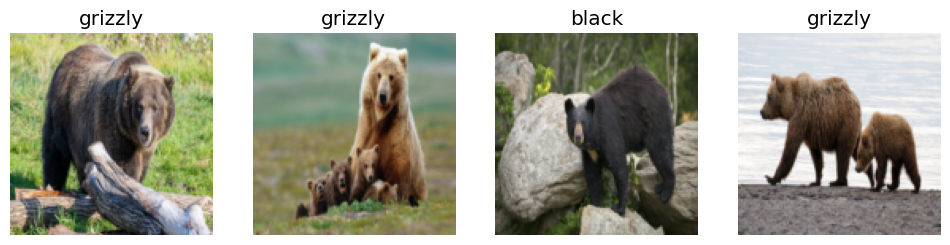

In [177]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

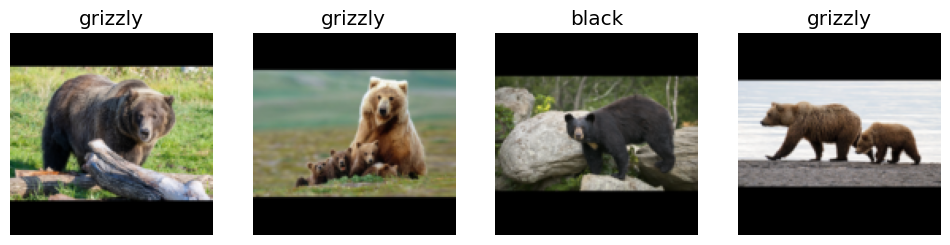

In [178]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

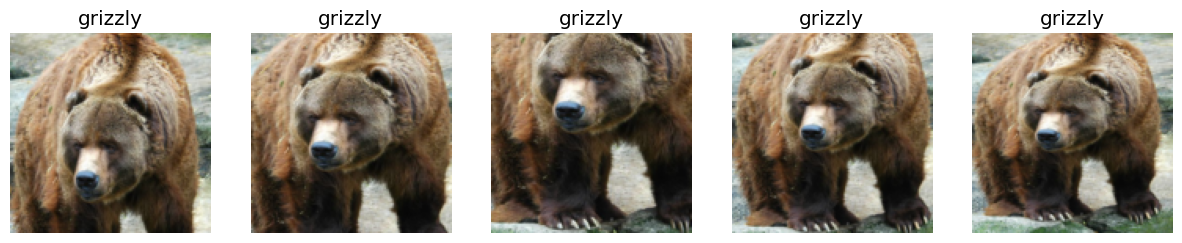

In [179]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=5, nrows=1, unique=True)


We used unique=True to have the same image repeated with different versions of this RandomResizedCrop transform. This is a specific example of a more general technique, called data augmentation.

# Data Augmentation
Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the aug_transforms function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the batch_tfms parameter (note that we're not using RandomResizedCrop in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):


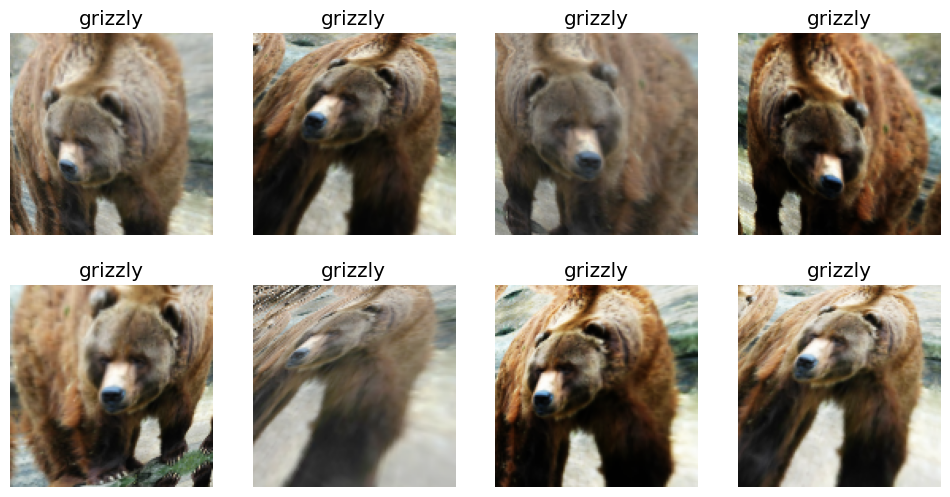

In [180]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training
We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use RandomResizedCrop with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

In [181]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [182]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\anaconda3\envs\fastbook\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a confusion matrix:

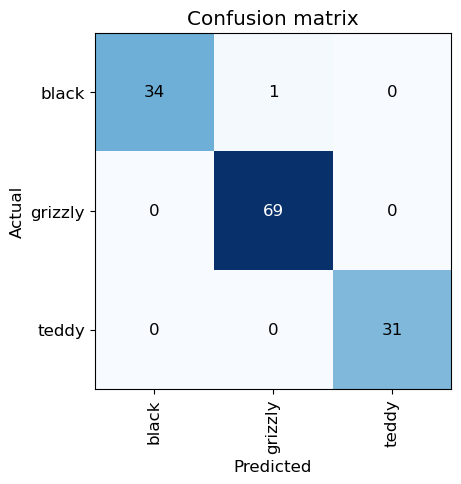

In [183]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, plot_top_losses shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction:

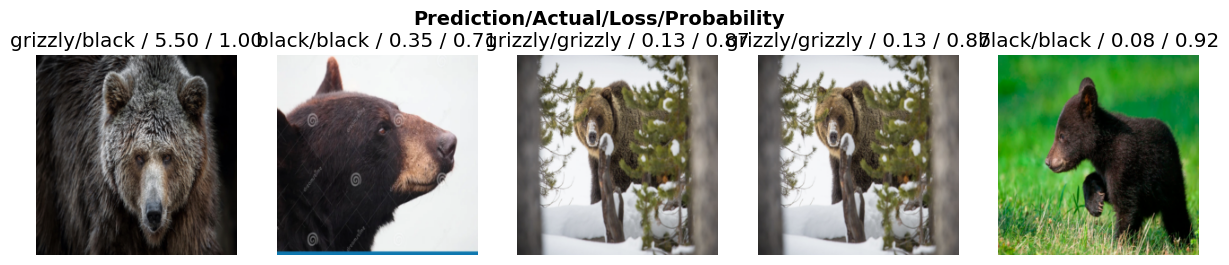

In [184]:
interp.plot_top_losses(5, nrows=1)

In [185]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

C:\anaconda3\envs\fastbook\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [186]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink() 
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [187]:
learn.export('model.pkl')

In [188]:
path = Path()
path.ls(file_exts='.pkl')


(#2) [Path('export.pkl'),Path('model.pkl')]

In [190]:
#|export
pk_fil='export.pkl'

In [191]:
#|export
learn_inf = load_learner(pk_fil)

In [192]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.8818e-04, 9.9981e-01, 8.2093e-07]))

In [193]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [18]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value=(), description='Upload')

In [19]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [20]:
img = PILImage.create(btn_upload.data[-1])

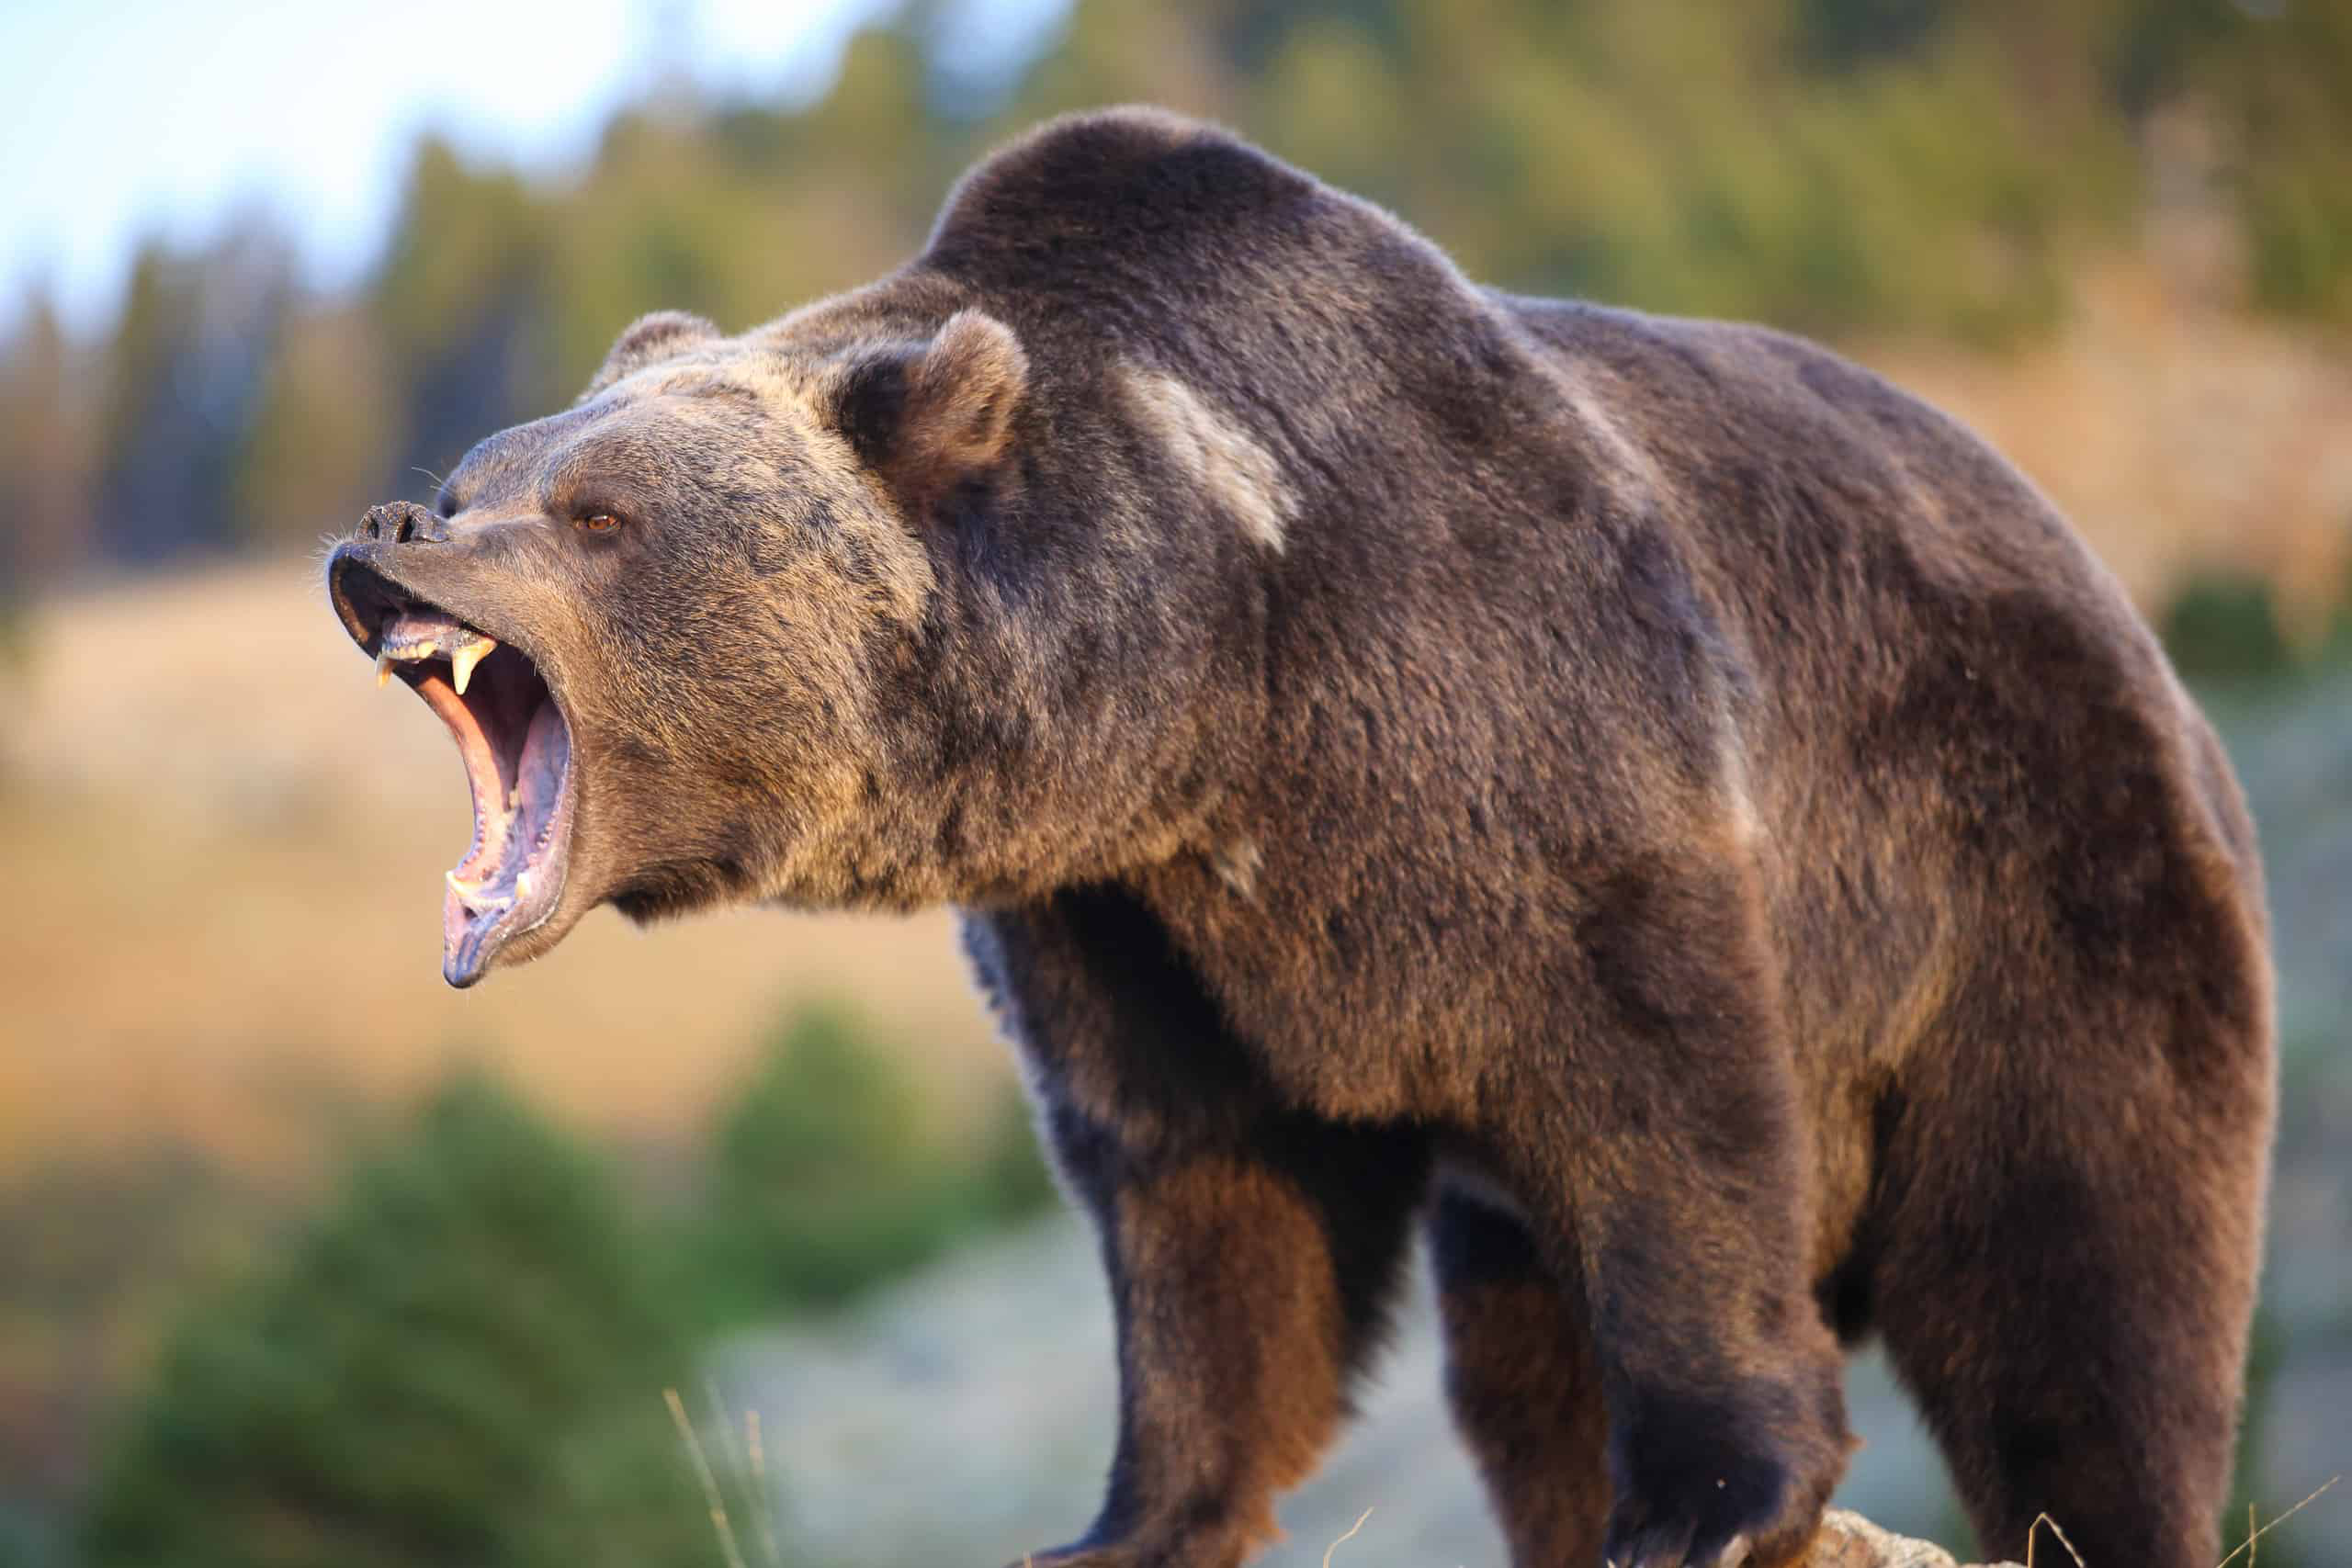

In [21]:
img

In [22]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [23]:
pred,pred_idx,probs = learn_inf.predict(img)

In [24]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9998')

In [25]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [26]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [27]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [28]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

# Gradio


In [25]:
!pip install gradio


   ---------------------------------------- 0.0/16.8 MB ? eta -:--:--
    --------------------------------------- 0.3/16.8 MB ? eta -:--:--
   ------- -------------------------------- 3.1/16.8 MB 10.3 MB/s eta 0:00:02
   ------------------ --------------------- 7.9/16.8 MB 17.4 MB/s eta 0:00:01
   --------------------------- ------------ 11.5/16.8 MB 16.8 MB/s eta 0:00:01
   ---------------------------------- ----- 14.7/16.8 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------- 16.8/16.8 MB 16.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------- ----------------------- 3.7/8.8 MB 18.2 MB/s eta 0:00:01
   --------------------------------- ------ 7.3/8.8 MB 17.4 MB/s eta 0:00:01
   ---------------------------------------- 8.8/8.8 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 13.0.1
    Uninstalling websockets-13.0.1:
      Successfully uninstalled websockets-13.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.7.2 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.5 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.5 which is incompatible.


In [194]:
#|export
import gradio as gr

In [195]:
#|export
labels = learn_inf.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn_inf.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [196]:

iface = gr.Interface(
    fn=predict, 
    inputs=gr.Image(type="pil"),  # No shape parameter, 'pil' type returns a PIL Image
    outputs=gr.Label(num_top_classes=3)
)

In [197]:
iface.close()

# Optional: Customization of our Gradio app

In [198]:
#|export
title = "Bear Classifier"
description = "A bear classifier. Created as a demo for Gradio and HuggingFace Spaces."

In [199]:
#|export
examples = ['images/grizzly.jpg']

In [34]:
interpretation='default'

In [35]:
enable_queue=True

In [200]:
#|export
iface = gr.Interface(
    fn=predict, 
    inputs=gr.Image(type="pil"),  # No shape parameter, 'pil' type returns a PIL Image
    outputs=gr.Label(num_top_classes=3),
    description=description,
    examples=examples,
    
    
).launch(share=True)

Running on local URL:  http://127.0.0.1:7869
Running on public URL: https://6280a179e46bbfe3a0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [66]:
!pip install jupyterlab-quarto

In [201]:
import nbdev
nbdev.export.nb_export(path/'Untitled.ipynb', './')


In [99]:
from nbdev.export import nb_export
nb_export('Untitled.ipynb', './')

Path('Untitled.ipynb')